In [69]:
import os
from pathlib import Path
import re
import random
from sklearn.model_selection import KFold
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import json
from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from models.unet import UNet
import torch.nn as nn
import torch.optim as optim

In [86]:
def draw_contours(contours):
    # Criar uma imagem binária inicializada com valores 0 (preto)
    imagem_binaria = np.zeros((256, 256), dtype=np.uint8)

    # Verificar o número de contornos
    if len(contours) == 1:
        # Caso haja apenas um contorno, converte e desenha diretamente
        contornos_np = np.array(contours[0], dtype=np.int32)
        cv2.drawContours(imagem_binaria, [contornos_np], -1, (255, 255, 255), thickness=cv2.FILLED)
    elif len(contours) == 0:
        return imagem_binaria
    else:
        # Caso haja mais de um contorno, converte cada um e desenha
        for contorno in contours:
            contornos_np = np.array(contorno, dtype=np.int32)
            cv2.drawContours(imagem_binaria, [contornos_np], -1, (255, 255, 255), thickness=cv2.FILLED)

    return imagem_binaria
    

def organize_masks(dataset_masks, data, camera, frame):
    
    dict_human = dataset_masks[f'{data}']
    dict_robot = dataset_masks[f'{data}_robot']
    
    for _, all_masks_found in dict_human.items():
        masks_data_camera = all_masks_found[f'subimage_{camera}']
        #print(len(masks_data_camera))
        contours_human = masks_data_camera[frame]
    
    for _, all_masks_found in dict_robot.items():
        masks_data_camera = all_masks_found[f'subimage_{camera}']
        #print(len(masks_data_camera))
        contours_robot = masks_data_camera[frame]
        
        #print(contours_human)
        
    
    return draw_contours(contours_human), draw_contours(contours_robot)
        
        
def transform_masks(mask_human, mask_robot, mask_mode=None):
    
    mask_human = np.where(mask_human > 0, 1, 0)
    mask_robot = np.where(mask_robot > 0, 1, 0)
    
    # Processar a máscara conforme o modo selecionado
    if mask_mode == "entropy":
        # Resolver sobreposição: prioridade para robô (ou humano, se preferir)
        mask = np.maximum(mask_robot, mask_human)

        # Converte a máscara para um tensor PyTorch e adiciona uma dimensão para o canal
        mask_tensor = torch.tensor(mask, dtype=torch.long).unsqueeze(0)
    else:
        # Cria uma máscara onde cada canal representa uma classe
        m, n = mask_human.shape
        mask = np.zeros((3, m, n), dtype=np.float32)
        mask[0] = 1 - (mask_human + mask_robot)  # Background
        mask[1] = mask_human  # Humano
        mask[2] = mask_robot  # Robô
        # Converte a máscara para um tensor PyTorch
        mask_tensor = torch.tensor(mask, dtype=torch.float32)
        
    return mask_tensor


# Define a custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, masks, transform=None, mask_mode=None):
        self.image_paths = image_paths
        self.masks = masks
        self.transform = transform
        self.mask_mode = mask_mode

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        #_, file_base_name = os.path.split(img_path)
        file_base_name = os.path.split(img_path)[1].split(".")[0]
        data, frame, camera = self.__get_mask_info__(file_base_name)
        #print(data, frame, camera)
        
        mask_human, mask_robot = organize_masks(self.masks, data, int(camera), int(frame))
        mask_tensor = transform_masks(mask_human, mask_robot, self.mask_mode)
        
        
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, mask_tensor
    
    def __get_mask_info__(self, strx):
        sub, act, rout, frame, camera = strx.split("_")
        return f"{sub}_{act}_{rout}", frame, camera

In [ ]:
def extrair_numero_regex(texto):
    padrao = r'\d+'
    numeros = re.findall(padrao, texto)
    if numeros:
        return numeros[0]
    else:
        return None


def process_json_namefile(strx):

    splited = strx.split("_")
    formated = f"{int(extrair_numero_regex(splited[0]))}_{int(extrair_numero_regex(splited[1]))}_{int(extrair_numero_regex(splited[2]))}"

    if "robot" in strx:
        formated += "_robot"
        
    return formated

    
def load_dataset_masks(pasta):
    # Inicializa o dicionário para armazenar os dados
    dados_json = {}

    # Lista todos os arquivos na pasta
    arquivos = os.listdir(pasta)

    # Filtra apenas os arquivos JSON
    arquivos_json = [arquivo for arquivo in arquivos if arquivo.endswith('.json')]

    # Processa cada arquivo JSON encontrado
    for arquivo_json in tqdm(arquivos_json):
        caminho_completo = os.path.join(pasta, arquivo_json)
        nome_arquivo = os.path.basename(arquivo_json)

        # Carrega o conteúdo do arquivo JSON como um dicionário
        with open(caminho_completo, 'r', encoding='utf-8') as f:
            conteudo = json.load(f)
        
        # Adiciona ao dicionário final usando o nome do arquivo como chave
        dados_json[process_json_namefile(nome_arquivo)] = conteudo
    
    return dados_json


def load_image_paths(directory):
    """Loads all image paths from the specified directory."""
    path = Path(directory)
    image_paths = list(path.glob('*.jpg'))
    return [str(img) for img in image_paths]


def group_images_by_prefix(image_paths):
    """Groups images by their prefix NUMSUBJECT_NUMACTIVITY_NUM_ROUTINE."""
    pattern = re.compile(r'(\d+)_(\d+)_(\d+)_\d+_\d+.jpg')
    grouped = {}
    for img_path in image_paths:
        match = pattern.search(os.path.basename(img_path))
        if match:
            prefix = f"{match.group(1)}_{match.group(2)}_{match.group(3)}"
            if prefix not in grouped:
                grouped[prefix] = []
            grouped[prefix].append(img_path)
    return list(grouped.values())


def create_dataloaders(image_groups, dataset_masks, n_splits=5, batch_size=32, transform=None, mask_mode=None):
    """Creates DataLoaders for cross-validation."""
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    dataloaders = []
    
    for train_index, val_index in kf.split(image_groups):
        train_images = [img for i in train_index for img in image_groups[i]]
        val_images = [img for i in val_index for img in image_groups[i]]
        
        train_dataset = CustomImageDataset(train_images, dataset_masks, transform, mask_mode)
        val_dataset = CustomImageDataset(val_images, dataset_masks, transform, mask_mode)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        dataloaders.append((train_loader, val_loader))
    
    return dataloaders


def show_masks(mask):
    plt.imshow(mask, cmap='gray')  # cmap='gray' garante que a imagem será mostrada em tons de cinza
    plt.title('Imagem de um canal')
    plt.colorbar()  # Adiciona uma barra de cores para referência
    plt.show()

In [76]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [77]:
image_directory = "C:/Users/iagor/Documents/git/data-definer/out/"
mask_directory = "C:/Users/iagor/Documents/git/human-segmentation-sam/out/"
batch_size = 32
n_splits = 5
    
transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])

In [44]:
dataset_masks = load_dataset_masks(mask_directory)
mask_mode = "entropy"

100%|██████████| 216/216 [00:58<00:00,  3.66it/s]


In [78]:
#hyper
num_epochs = 10
learning_rate = 0.001

# Model, loss, optimizer
model = UNet(n_channels=3, n_classes=3, bilinear=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [87]:
image_paths = load_image_paths(image_directory)
image_groups = group_images_by_prefix(image_paths)
dataloaders = create_dataloaders(image_groups, dataset_masks, n_splits, batch_size, transform, mask_mode)    
    
for fold, (train_loader, val_loader) in enumerate(dataloaders):
    print(f"Fold {fold+1}")
    # for images, masks in train_loader:
    #     print(f"Train batch: {images.size()} and {masks.size()}")
    # for images, masks in val_loader:
    #     print(f"Validation batch: {images.size()} and {masks.size()}")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, masks in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            masks = masks.long()
            loss = criterion(outputs, masks.squeeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Fold {fold+1}, Epoch {epoch+1}, Training Loss: {epoch_loss:.4f}")

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                outputs = model(images)
                masks = masks.long()
                loss = criterion(outputs, masks.squeeze(1))
                val_loss += loss.item() * images.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        print(f"Fold {fold+1}, Epoch {epoch+1}, Validation Loss: {val_loss:.4f}")
    


Fold 1


In [81]:
torch.unique(masks)

tensor([0, 1, 2, 3])

Fold 1
Found a mask with value 3


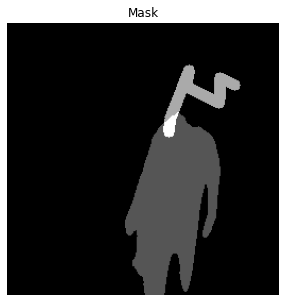

Fold 2
Found a mask with value 3


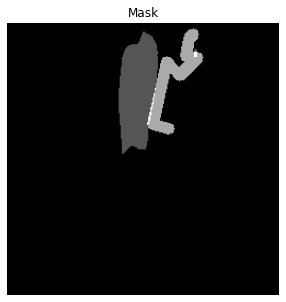

Fold 3
Found a mask with value 3


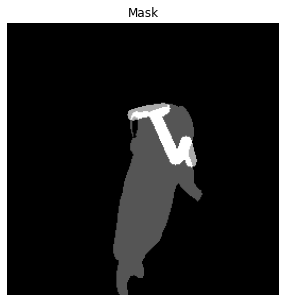

Fold 4
Found a mask with value 3


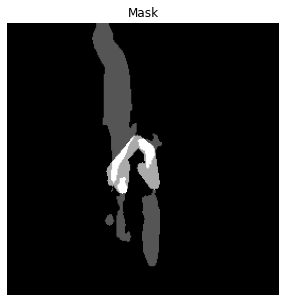

Fold 5
Found a mask with value 3


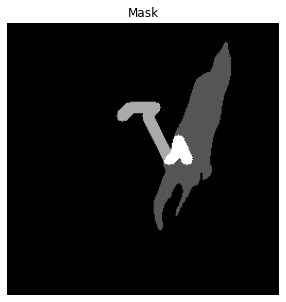

In [84]:
def visualize_mask(mask):
    plt.figure(figsize=(5, 5))
    mask = mask.squeeze(0).cpu().numpy()
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')
    plt.show()

# Assuming dataloaders and model are already defined as in previous code
for fold, (train_loader, val_loader) in enumerate(dataloaders):
    print(f"Fold {fold+1}")
    
    for images, masks in train_loader:
        for mask in masks:
            if 3 in torch.unique(mask):
                print("Found a mask with value 3")
                visualize_mask(mask)
                break  # Visualize only the first problematic mask
        break  # Check only the first batch for simplicity

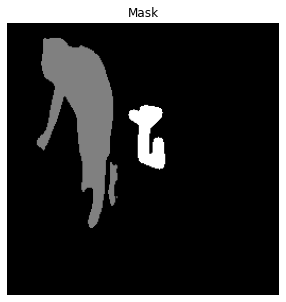

In [82]:
plt.figure(figsize=(5, 5))
mask = masks[0].squeeze(0).cpu().numpy()
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.axis('off')
plt.show()

torch.Size([1, 3, 256, 256])


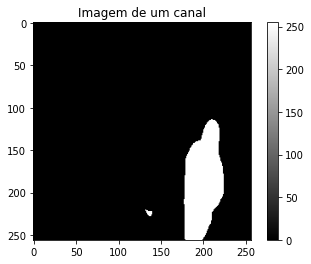

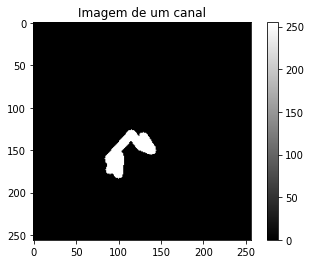

In [53]:
def transform_masks(mask_human, mask_robot, mask_mode=None):
    
    # Processar a máscara conforme o modo selecionado
    if mask_mode == "entropy":
        # Cria uma máscara onde a perda de entropia cruzada pode ser aplicada
        mask = mask_human + (mask_robot * 2)
    else:
        # Cria uma máscara onde cada canal representa uma classe
        m, n = mask_human.shape
        mask = np.zeros((3, m, n), dtype=np.float32)
        mask[0] = 1 - (mask_human + mask_robot)  # Background
        mask[1] = mask_human  # Humano
        mask[2] = mask_robot  # Robô
        
    # Converte a máscara para um tensor PyTorch
    mask_tensor = torch.tensor(mask, dtype=torch.float32)

    # Expande a dimensão do tensor da máscara para corresponder ao batch
    mask_tensor = mask_tensor.unsqueeze(0)
    
    return mask_tensor


def draw_contours(contours):
    # Criar uma imagem binária inicializada com valores 0 (preto)
    imagem_binaria = np.zeros((256, 256), dtype=np.uint8)

    # Verificar o número de contornos
    if len(contours) == 1:
        # Caso haja apenas um contorno, converte e desenha diretamente
        contornos_np = np.array(contours[0], dtype=np.int32)
        cv2.drawContours(imagem_binaria, [contornos_np], -1, (255, 255, 255), thickness=cv2.FILLED)
    elif len(contours) == 0:
        return imagem_binaria
    else:
        # Caso haja mais de um contorno, converte cada um e desenha
        for contorno in contours:
            contornos_np = np.array(contorno, dtype=np.int32)
            cv2.drawContours(imagem_binaria, [contornos_np], -1, (255, 255, 255), thickness=cv2.FILLED)

    return imagem_binaria
    

def organize_masks(dataset_masks, data, camera, frame):
    
    dict_human = dataset_masks[f'{data}']
    dict_robot = dataset_masks[f'{data}_robot']
    
    for _, all_masks_found in dict_human.items():
        masks_data_camera = all_masks_found[f'subimage_{camera}']
        #print(len(masks_data_camera))
        contours_human = masks_data_camera[frame]
    
    for _, all_masks_found in dict_robot.items():
        masks_data_camera = all_masks_found[f'subimage_{camera}']
        #print(len(masks_data_camera))
        contours_robot = masks_data_camera[frame]
        
        #print(contours_human)
        
    
    return draw_contours(contours_human), draw_contours(contours_robot)
    

data, frame, camera = "2_1_2", 180, 3

mask_human, mask_robot = organize_masks(dataset_masks, data, camera, frame)
mask_tensor = transform_masks(mask_human, mask_robot)
print(mask_tensor.shape)
show_masks(mask_human)
show_masks(mask_robot)

In [11]:
mask_robot.shape

(256, 256)

In [24]:
cu = [[[[132, 220]], [[132, 221]], [[133, 222]], [[133, 223]], [[134, 224]], [[134, 225]], [[136, 227]], [[138, 227]], [[138, 226]], [[139, 225]], [[139, 222]], [[135, 222]], [[134, 221]], [[133, 221]]], [[[209, 114]], [[208, 115]], [[207, 115]], [[204, 118]], [[204, 119]], [[202, 121]], [[202, 123]], [[201, 124]], [[201, 125]], [[200, 126]], [[200, 129]], [[199, 130]], [[199, 132]], [[198, 133]], [[198, 136]], [[197, 137]], [[197, 138]], [[196, 139]], [[194, 139]], [[193, 140]], [[191, 140]], [[189, 142]], [[188, 142]], [[188, 143]], [[186, 145]], [[186, 146]], [[184, 148]], [[184, 150]], [[183, 151]], [[183, 152]], [[182, 153]], [[182, 154]], [[181, 155]], [[181, 156]], [[180, 157]], [[180, 159]], [[179, 160]], [[179, 179]], [[178, 180]], [[178, 207]], [[177, 208]], [[177, 213]], [[178, 214]], [[178, 254]], [[179, 255]], [[198, 255]], [[199, 254]], [[199, 253]], [[201, 251]], [[201, 250]], [[202, 249]], [[202, 248]], [[203, 247]], [[203, 245]], [[204, 244]], [[204, 243]], [[205, 242]], [[205, 240]], [[206, 239]], [[206, 238]], [[208, 236]], [[208, 233]], [[209, 232]], [[209, 223]], [[211, 221]], [[211, 220]], [[217, 214]], [[217, 213]], [[218, 212]], [[218, 211]], [[219, 210]], [[219, 208]], [[221, 206]], [[221, 205]], [[222, 204]], [[222, 202]], [[223, 201]], [[223, 178]], [[222, 177]], [[222, 169]], [[221, 168]], [[221, 165]], [[220, 164]], [[220, 163]], [[219, 162]], [[219, 159]], [[218, 158]], [[218, 156]], [[217, 155]], [[217, 140]], [[218, 139]], [[218, 124]], [[217, 123]], [[217, 120]], [[215, 118]], [[215, 117]], [[213, 115]], [[211, 115]], [[210, 114]]]]

In [25]:
len(cu)

2